In [113]:
import pandas as pd
import numpy as np
train = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
train = train[(train['Recidivism_Arrest_Year1']==False) & (train['Recidivism_Arrest_Year2']==False)]
test = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Test_Dataset3.csv')
train  = pd.concat([train[test.columns], train['Recidivism_Arrest_Year3']], axis =1)
train = pd.concat([train,test]).reset_index(drop=True)


for i in train.columns:
    if train[i].dtypes == 'object':
        train[i] = train[i].astype(str).str.replace(' or more', '').replace('nan', np.nan)


int_variables = ['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',\
'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Felony',\
'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Delinquency_Reports',\
                'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 'Dependents']
for i in int_variables:
    train[i] = train[i].astype('int')
    
bool_variables = [i for i in train.columns if train[i].dtypes == 'bool']


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
nan_variables = ['Gang_Affiliated', 'Supervision_Risk_Score_First', 'Supervision_Level_First', 'Prison_Offense', \
                 'Recidivism_Arrest_Year3', 'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive','DrugTests_Cocaine_Positive', \
                 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_var = ['Gender', 'Race']


one_hot_variables = ['Age_at_Release','Residence_PUMA', 'Education_Level' , 'Prison_Years']

In [114]:
train['Residence_PUMA'] = train['Residence_PUMA'].astype('str')

dummies = pd.get_dummies(train[one_hot_variables])

train = train.drop(one_hot_variables, axis = 1)
train = pd.concat([train,dummies], axis=1)

for i in cat_var + bool_variables:
    train[i] = labelencoder.fit_transform(train[i])

for i in nan_variables:
    train[nan_variables] = train[nan_variables].replace('nan', np.nan)

original = train[nan_variables]
mask = train[nan_variables].isnull()

for i in nan_variables:
    if train[i].dtypes == 'object':
        train[i] = labelencoder.fit_transform(train[i].astype('str'))

train[nan_variables] = train[nan_variables].where(~mask, original)

train[nan_variables] = train[nan_variables].astype('float')

train['Recidivism_Arrest_Year3'] = train['Recidivism_Arrest_Year3'].astype('float')

In [115]:
feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]
train[feats] = train[feats].fillna(-1)

train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
test_df = train[train['Recidivism_Arrest_Year3'].isnull()]

X = train_df[feats]
y  = train_df['Recidivism_Arrest_Year3']

In [116]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(1000,2000,200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [117]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_estimators = 2000)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=50, random_state=42, n_jobs = -1, scoring = 'roc_auc')
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  2.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed:  4.9min remaining:   16.7s
[Parallel(n_jobs=-1)]: Done 291 out of 300 | elapsed:  5.0min remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:  5.2min remaining:    2.1s
[Parallel(n_j

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=2000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, scoring='roc_auc', verbose=50)

In [118]:
print('Best Score: ', rf_random.best_score_)
print('Best Params: ', rf_random.best_params_)

Best Score:  0.6812818327811091
Best Params:  {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [119]:
rf_random.cv_results_

{'mean_fit_time': array([20.3399392 , 10.97488817, 18.71931783, 11.07716282, 11.39980086,
         9.63200355, 14.61799796, 14.51745097,  7.92843898, 12.45823884,
        11.4725004 , 10.93247573,  8.33533446, 11.63015207,  9.21860774,
         7.21734754,  8.95747066, 11.93763018, 10.76543903, 10.50219131,
         7.61003812, 16.18891271, 10.11315672,  9.5785044 ,  6.56427805,
        11.68507544,  6.62172055,  7.88500182,  9.34321928,  6.79325247,
        17.8756849 , 14.29945866,  8.13482046, 13.52335501, 12.10746336,
        12.93762509, 15.20521466, 12.49878685,  9.79993733, 10.99656367,
        11.26474897, 17.0170633 , 10.92283654,  7.73146113, 14.44762309,
        14.35833621, 15.06622211, 10.566866  ,  9.15544279, 12.33911324,
        11.74068793,  7.74748532, 16.38673894,  8.95123204, 11.23566477,
        10.70278136, 18.26762136,  9.10416245, 12.48436459,  9.68082428,
        11.10722462, 11.50378537, 18.58497492,  7.04992509,  6.61092687,
         8.11053975,  7.74732471, 

In [121]:
param_1 = rf_random.cv_results_['params'][rf_random.best_index_]

In [120]:
param_2 = rf_random.cv_results_['params'][83]

In [122]:
param_3 = rf_random.cv_results_['params'][3]

In [123]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [124]:
import gc
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
def kfold_rf(X,y, num_folds, best_params):
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        global valid_x
        train_x, train_y = X.iloc[train_idx], y[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y[valid_idx]
        clf = RandomForestClassifier(
            **best_params
        )
        clf.fit(train_x, train_y)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
            fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        gc.collect()
    print('Full F&A score %.6f' % roc_auc_score(train_df['Recidivism_Arrest_Year3'], oof_preds))
    display_importances(feature_importance_df)
    return sub_preds, oof_preds

Full F&A score 0.681818


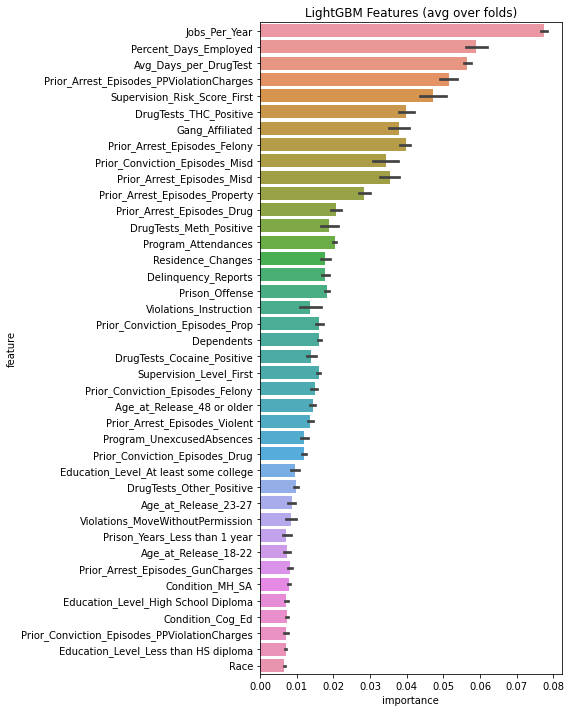

In [126]:
preds_rf_1, oof_rf_1 = kfold_rf(X,y, 5, param_1)


Full F&A score 0.681776


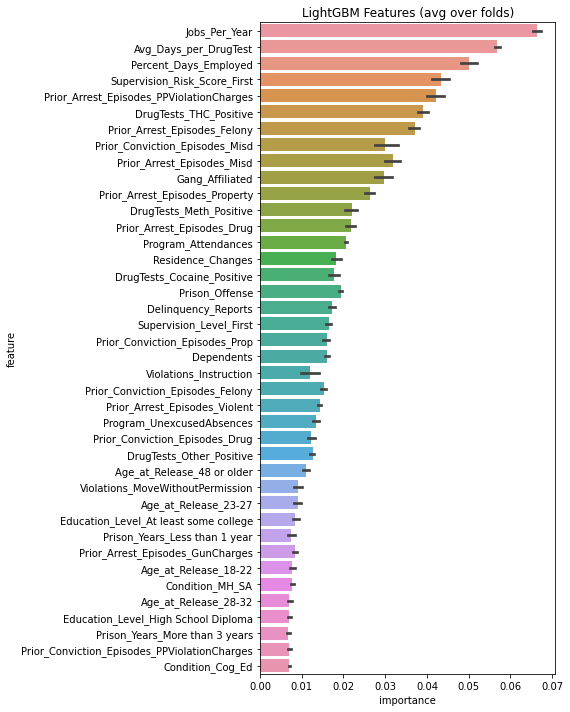

In [127]:
preds_rf_2, oof_rf_2 = kfold_rf(X,y, 5, param_2)


Full F&A score 0.681766


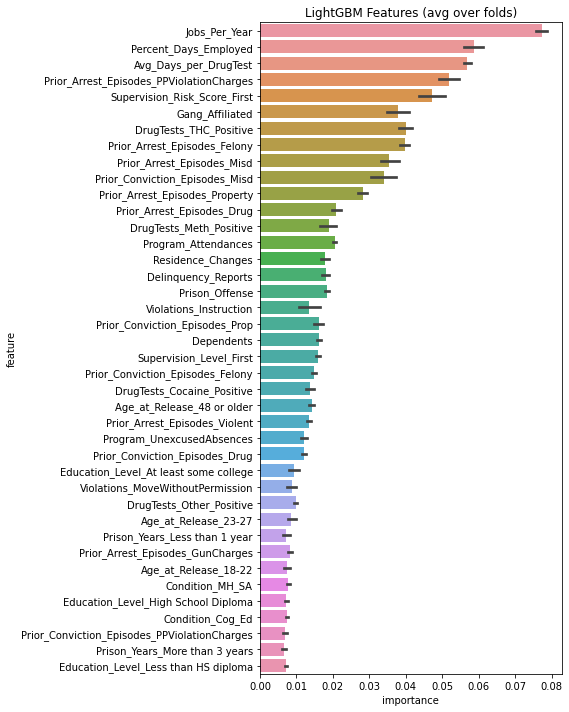

In [128]:
preds_rf_3, oof_rf_3 = kfold_rf(X,y, 5, param_3)

In [129]:
rf_train = pd.DataFrame(data={
    "rf_1": oof_rf_1.tolist(),
    "rf_2": oof_rf_2.tolist(),
    "rf_3": oof_rf_3.tolist()
})
rf_test = pd.DataFrame(data={
    "rf_1": preds_rf_1.tolist(),
    "rf_2": preds_rf_2.tolist(),
    "rf_3": preds_rf_3.tolist()
})

In [130]:
rf_train.to_csv('rf_train.csv', index = False)
rf_test.to_csv('rf_test.csv', index = False)